# Multiple Adjacency Spectral Embedding (MASE)

Multiple Adjacency Spectral Embedding (MASE) is an extension of Adjacency Spectral Embedding (see ASE [tutorial](https://graspy.neurodata.io/tutorials/embedding/adjacencyspectralembed)) for an arbitrary number of graphs.  Once graphs are embedded, the low-dimensional Euclidean representation can be used to visualize the latent positions of vertices, perform inference, etc.

In [1]:
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline

## Replicating Omnibus Embedding Tutorial

In order to demonstrate how to use the ``MultipleASE`` class, we will use a simple example: two 2-block stochastic block models (SBMs) with different block probabilities.  Indeed, we will use the same models as in the omnibus [tutorial](https://graspy.neurodata.io/tutorials/embedding/omnibus) to facilitate direct comparison. 

## Simulate two different graphs using stochastic block models (SBM)

We sample two 2-block SBMs (undirected, no self-loops) with 50 vertices, each block containing 25 vertices ($n = [25, 25]$), and with the following block connectivity matrices:

\begin{align*}
B_1 = 
\begin{bmatrix}0.3 & 0.1\\
0.1 & 0.7
\end{bmatrix},~
B_2 = \begin{bmatrix}0.3 & 0.1\\
0.1 & 0.3
\end{bmatrix}
\end{align*}

The only difference between the two is the within-block probability for the second block. We sample $G_1 \sim \text{SBM}(n, B_1)$ and $G_2 \sim \text{SBM}(n, B_2)$.

In [2]:
from graspologic.simulations import sbm

n = [25, 25]
B1 = [[0.3, 0.1],
      [0.1, 0.7]]
B2 = [[0.3, 0.1],
      [0.1, 0.3]]

np.random.seed(8)
G1 = sbm(n, B1)
G2 = sbm(n, B2)

/opt/hostedtoolcache/Python/3.8.13/x64/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Visualize the graphs using heatmap

We visualize the sampled graphs using the ``heatmap()`` function. ``heatmap()`` will plot the adjacency matrix, where the colors represent the weight of each edge. In this case, we have binary graphs so the values will be either 0 or 1. 

We see that there is clear block structure to the graphs. Furthermore, the lower right quarter of $G_1$, representing the within-group connections for the second group, is more dense than that of $G_2$.

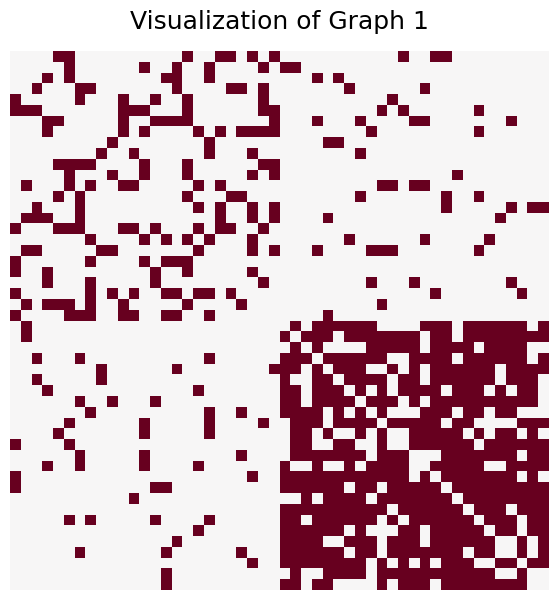

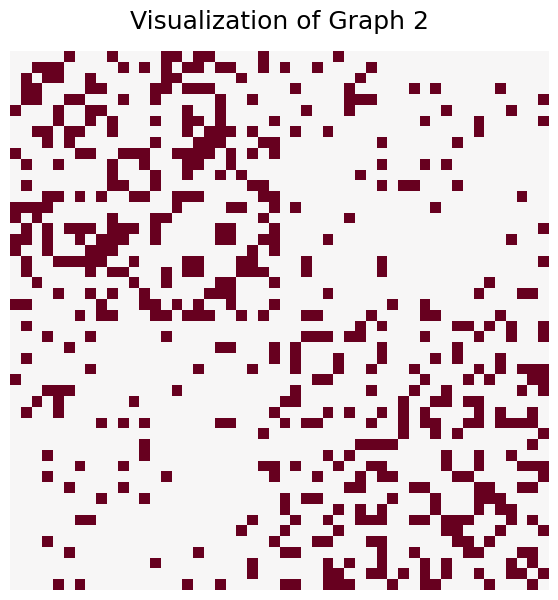

In [3]:
from graspologic.plot import heatmap

heatmap(G1, figsize=(7,7), title="Visualization of Graph 1", cbar=False)
_ = heatmap(G2, figsize=(7,7), title="Visualization of Graph 2", cbar=False)

## Embed the two graphs using MASE

Just as ASE fits a single input graph to the Random Dot Product Graph (RDPG) model, MASE fits many input graphs to the common subspace independent-edge (COSIE) model, which is an extension of the RDPG model to multiple graphs. The COSIE model assumes that all of the graphs have important shared properties, but can also have meaningful differences.  As a result, COSIE decomposes the set of graphs into a set of shared latent positions $V$ that describe similarities, and a set of score matrices $R^{(i)}$ that describe how each individual graph is different.  Mathematically, for the adjacency matrix of an undirected graph $A^{(i)}$,
$$A^{(i)} = VR^{(i)}V^T$$

In general, 2 clusters can be faithfully represented in 2 dimensions, so we specify the number of components as 2. Then, the ``fit_transform()`` method returns the estimated latent positions $\hat{V}$, which we can see has 50 entries corresponding to the 50 vertices embedded in 2 dimensions.

In [4]:
from graspologic.embed import MultipleASE as MASE

embedder = MASE(n_components=2)
V_hat = embedder.fit_transform([G1, G2])
print(V_hat.shape)

(50, 2)


## Visualize Common Latent Positions

Since the two graphs have clear block structures, with higher within-block probabilities than between-block, we see two distinct "clusters" when we visualize the shared latent positions.

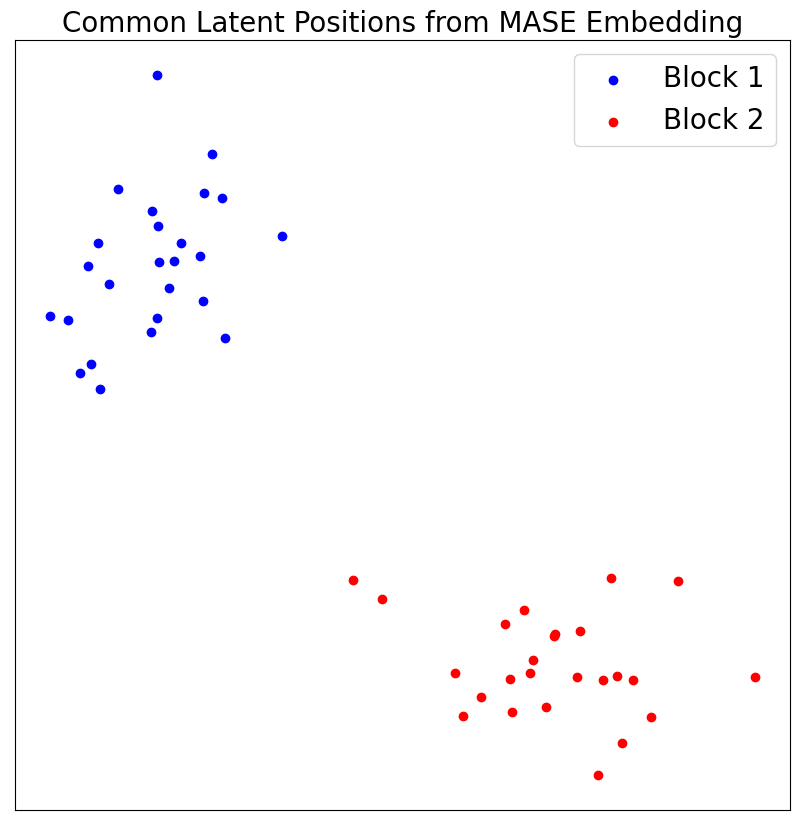

In [5]:
def vis_latent(V, title, predicted=False, pred_labels=None):
    fig, ax = plt.subplots(figsize=(10,10))
    if predicted:
        ax.scatter(V_hat[pred_labels==0, 0], V_hat[pred_labels==0, 1], c="blue", label="Predicted Block 1")
        ax.scatter(V_hat[pred_labels==1, 0], V_hat[pred_labels==1, 1], c="red", label="Predicted Block 2")
    else:
        ax.scatter(V[:25, 0], V[:25, 1], c="blue", label="Block 1")
        ax.scatter(V[25:, 0], V[25:, 1], c="red", label="Block 2")
        
    ax.legend(prop={'size':20})
    ax.set_xticklabels([])
    ax.set_yticklabels([])
    ax.set_xticks([])
    ax.set_yticks([])
    _ = ax.set_title(title, fontsize=20)

vis_latent(V_hat, "Common Latent Positions from MASE Embedding")

## Recover Original Communities

We can apply a simple clustering algorithm (kmeans) to recover the original communities.

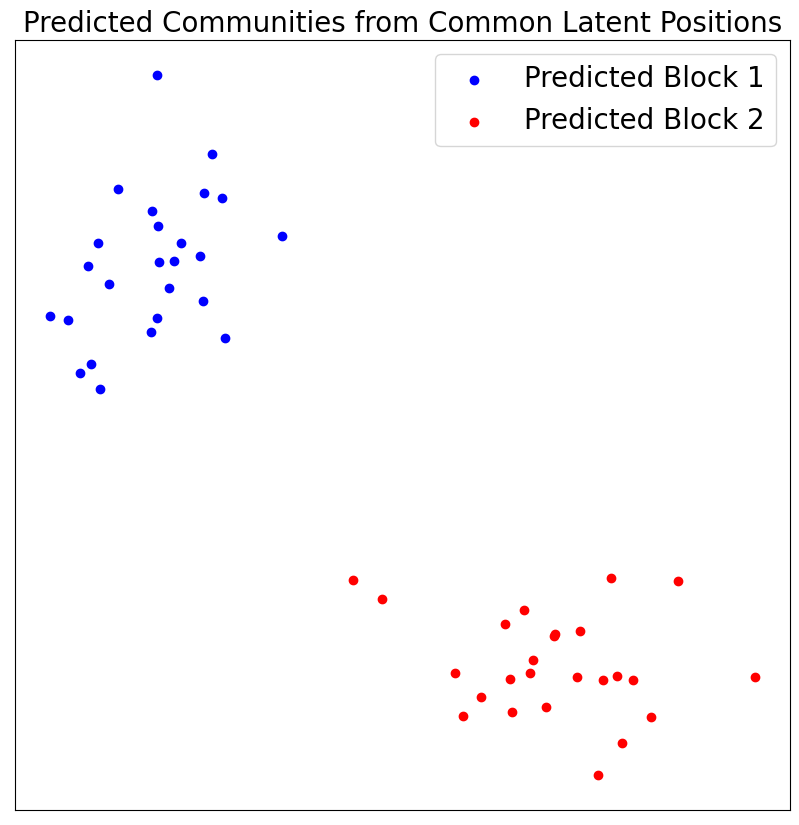

In [6]:
#Cluster V_hat
from graspologic.cluster import KMeansCluster
clusterer = KMeansCluster()
pred_labels = clusterer.fit_predict(V_hat)

#Remap labels
from graspologic.utils import remap_labels
true_labels = [0]*25 + [1]*25
remapped_labels = remap_labels(true_labels, pred_labels)

#Visualize latent positions
vis_latent(V_hat, "Predicted Communities from Common Latent Positions", True, remapped_labels)

Even with only one graph sampled from each SBM, we can perfectly recover the two communities!

## Sampling More Graphs

We can recover a more accurate representation of the two SBM populations with more sample graphs.  Let's try with 100 graphs sampled from each.

In [7]:
G1 = [sbm(n, B1) for i in range(100)]
G2 = [sbm(n, B2) for i in range(100)]

V_hat = embedder.fit_transform(G1 + G2)

## Visualizing Common Latent Subspace

Now, the clustering is even more distinct, as we would expect with more samples.

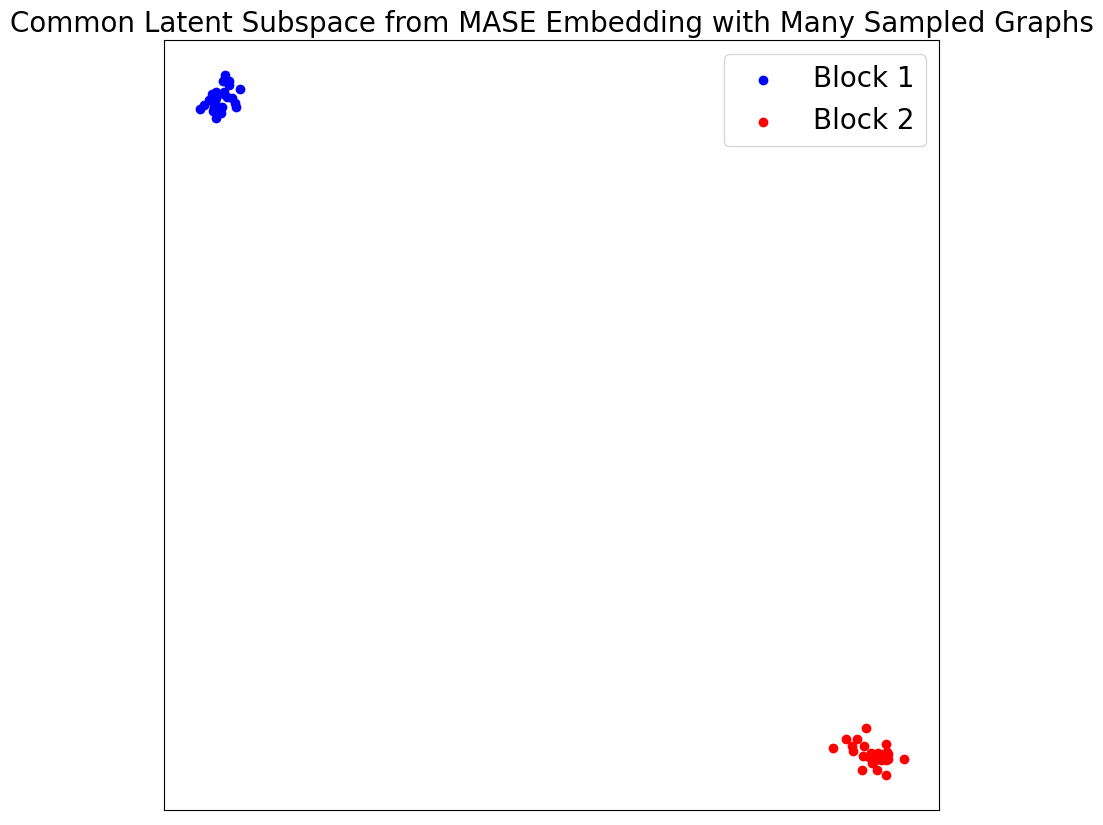

In [8]:
vis_latent(V_hat, "Common Latent Subspace from MASE Embedding with Many Sampled Graphs")

## Visualize Score Matrices

Now that we have more samples, we can apply the same process to visualize the individual score matrices.  Note, since the score matrices are symmetric, $2 \times 2$ matrices, we only need a 3-dimensional vector to represent each.  In this case, we can clearly see two distinct clusters: one for the score matrices from the first SBM population another for the score matrices from the second.

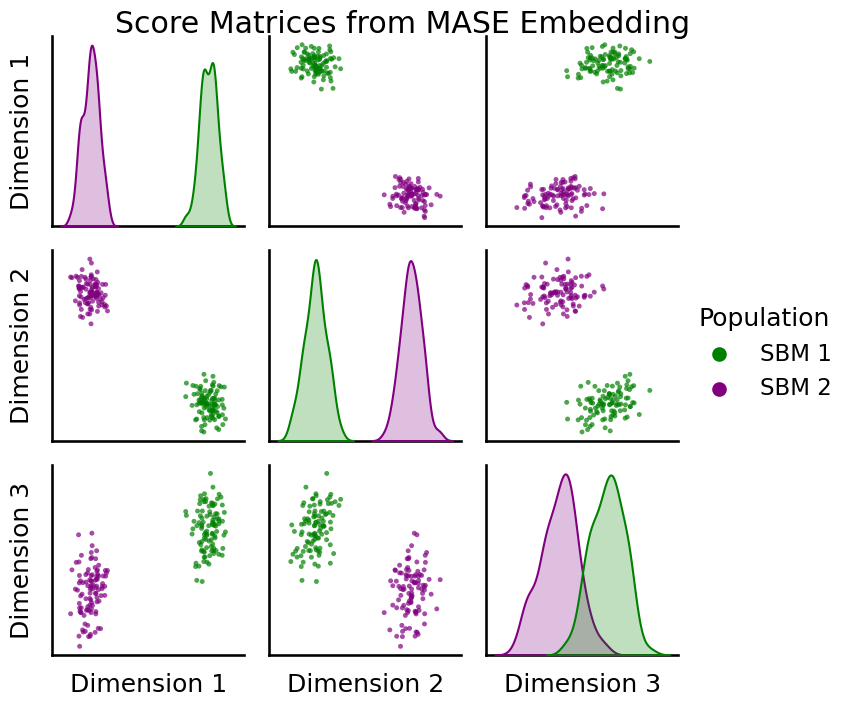

In [9]:
from graspologic.plot import pairplot

#Extract Score Matrices (in vector form)
R_1_hat = np.reshape(embedder.scores_[:100], (100, 4))
R_2_hat = np.reshape(embedder.scores_[100:], (100, 4))

#Omitting redundant entries due to symmetry
R_1_hat = np.delete(R_1_hat, 1, axis=1)
R_2_hat = np.delete(R_2_hat, 1, axis=1)

#Combining into a single array
R_hat = np.concatenate((R_1_hat, R_2_hat), axis=0)

#Visualize
labels = ["SBM 1"]*100 + ["SBM 2"]*100
_ = pairplot(R_hat, labels, title="Score Matrices from MASE Embedding",
             palette={"green", "purple"}, legend_name="Population")

## Recover Original SBM Membership

As before, we can apply a simple clustering algorithm (kmeans) to recover from which SBM population each graph was generated.

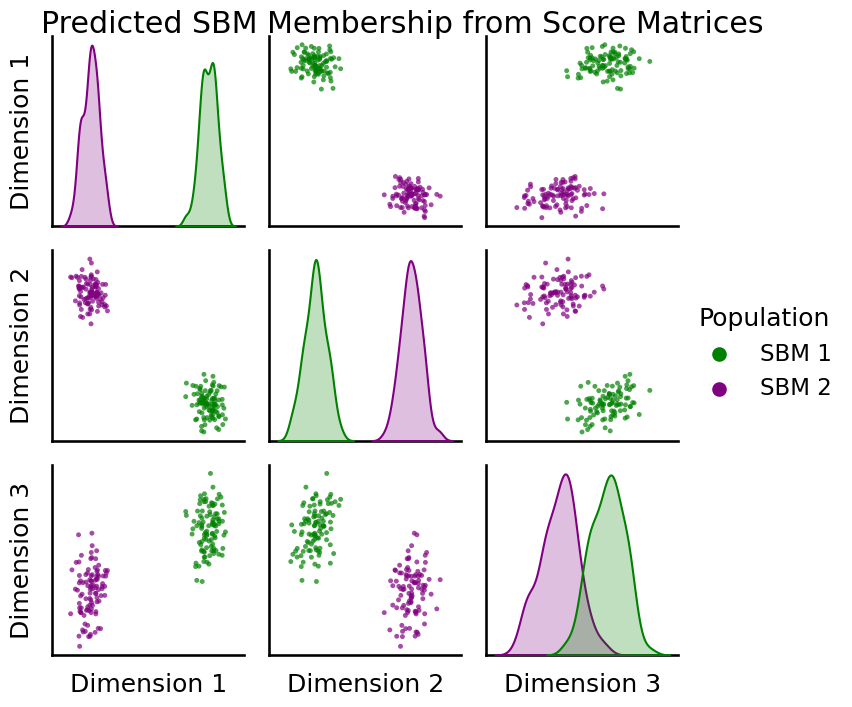

In [10]:
#Cluster R_hat
pred_labels = clusterer.fit_predict(R_hat)
true_labels = [0]*100 + [1]*100
remapped_labels = remap_labels(true_labels, pred_labels)
pred_sbm = []
for label in remapped_labels:
    if label == 0:
        pred_sbm.append("SBM 1")
    else:
        pred_sbm.append("SBM 2")

#Visualize Results
_ = pairplot(R_hat, pred_sbm, title="Predicted SBM Membership from Score Matrices",
             palette={"green", "purple"}, legend_name="Population")

With this method we can perfectly recover the original SBM population to which each graph belongs!